# Описание задачи

Данная задача на бинарную классификацию.

**Цель:**<br>
В данной задаче мы будем предсказывать был ли пассажир космического корабля Титаник перенесен в альтернативное измерение или нет во время столкновения с пространственно-временной аномалией.

Задача взята с соревновательной платформы kaggle https://www.kaggle.com/competitions/spaceship-titanic/overview

**Имеющиеся данные:**
 + PassengerId - записано в формате gggg_pp, где gggg - группа пассажира, pp - его id внутри группы
 + HomePlanet - родная планета
 + CryoSleep - бал или нет помещен в криосон
 + Cabin - имеет форму deck/num/side, где deck - палуба 
 + Destination - направление
 + Age - возраст
 + VIP
 + RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - сумма за каждое из этих удобств
 + Name - имя
 + Transported - был или нет транспортирован в другое измерение - наша целевая перменная
 
 
 **Результат:** точность предсказания около 80%

# Начало работы

## Подключение библиотек

In [818]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.tree import DecisionTreeRegressor

from scipy.stats import chi2_contingency
from scipy.stats import chisquare
from scipy.stats import ttest_ind

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix


%matplotlib inline
sns.set(rc={"figure.figsize": (20, 20)})
sns.set_style("whitegrid")

## Функции и переменные

In [603]:
RANDOM_STATE = 100
SPLIT_TEST_SIZE = 0.2 # размер тестовой выборки
NUM_SPLIT_FOR_GRID = 5 #на сколько частей будет разбиваться выборка при подборе параметров
TRESHOLD_FOR_CORR = 0.1 #порог значения корреляции, ниже которого будем отбрасывать признаки
TRESHOLD_FOR_HIGH_CORR = 0.6 #при этом пороге корреляции будем тщательнее исследовать на предмет выбросов
TRESHOLD_FOR_HIGH_CORR_BETWEEN_FEATURE = 0.8 #если корреляция выше - удаляемм один из коррелируемых признаков 
COLOR_PLOT = 'deepskyblue'

def add_into_list(list_el, new_el):
    """
    Функция добавления списка элементов в массив
    """
    if np.isin(new_el, list_el).sum() == 0:
        return np.append(list_el, new_el)
    else:
        return list_el
    
def del_from_list(list_el, new_el):
    """
    Функция удаления элементов из массива
    """
    if np.isin(new_el, list_el).sum():
        return np.setdiff1d(list_el, new_el)
    else:
        return list_el
    
def ksi(data, X, Y):
    for i, j in zip(X, Y):

        CrosstabResult = pd.crosstab(index=train[i], columns=train[j])
        
        ChiSqResult = chi2_contingency(CrosstabResult)
        print(f"P-Value χ² теста между группами {i} и {j} = {ChiSqResult[1]}\n")

## Загрузка данных

In [604]:
train = pd.read_csv('data/train.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [605]:
test = pd.read_csv('data/test.csv')
#запомним id тестовой - он нужен для загрузки в kaggle, но при анализе удалится ввиду неинформативности для модели 
test_id = test.PassengerId
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


## Основная информация о данных

In [606]:
print('Форма тренировочной выборки: ' + str(train.shape))
print('Форма тестовой выборки: ' + str(test.shape))

Форма тренировочной выборки: (8693, 14)
Форма тестовой выборки: (4277, 13)


In [607]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Мы видим, что во всех признаках, кроме id и целевого, имеются пропущенные значения. Помимо этого, стоит разбить колонки PassengerId, Cabin (Destination - под вопросом, выясним позже в процессе анализа категориальных переменных) на несколько значений. И удалить колонку с именем и id пользователя внутри группы ввиду их неинформативности. 

## Проверка на дубликаты

In [608]:
print(f'Дубликаты в тренировочной выборке: {train.duplicated().sum()} ({np.round(100*train.duplicated().sum()/train.shape[0],2)}%)')
print(f'Дубликаты в тестовой выборке: {test.duplicated().sum()} ({np.round(100*test.duplicated().sum()/test.shape[0],2)}%)')

Дубликаты в тренировочной выборке: 0 (0.0%)
Дубликаты в тестовой выборке: 0 (0.0%)


# Анализ целевой переменной

Здесь мы рассмотрим на сколько сбалансированы наши классы целевой переменной

In [609]:
val_transp = train.Transported.value_counts()
val_transp

True     4378
False    4315
Name: Transported, dtype: int64

In [610]:
transp = train[train.Transported].shape[0]
transp

4378

In [611]:
not_transp = train[~train.Transported].shape[0]
not_transp

4315

Воспользуемся  χ² для оценки равномерности распределения классов

In [612]:
ChiSqResult = chisquare([transp,not_transp])
print( f"P-Value χ² теста между группами  = {ChiSqResult[1]}\n")

P-Value χ² теста между группами  = 0.49922936670420104



По критерию χ² значения целевой переменной распределены равномерно, поэтому можно пользоваться метриками accuracy. В реальной задаче нам скорее потребовались метрики f beta score, где beta > 1, тк было бы важнее сделать акцент на полноте, а не точности (важно найти всех транспортировавшихся), но в данной соревновательной задаче нам важна именно точность предсказания и сведение ошибки к минимуму.

Построим график распределения значений целевого признака

Text(0.5, 1.0, 'Распределение целевой переменной')

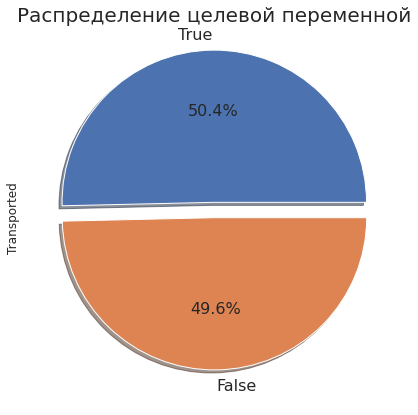

In [613]:
plt.figure(figsize=(7,7))
train.Transported.value_counts().plot.pie(explode=[0.1,0.001], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).\
    set_title('Распределение целевой переменной', fontsize=20)

**Вывод: наши классы сбалансированы, разница между ними не существенна, в пределах статистической погрешности**

# Типы данных

In [614]:
train.dtypes.value_counts()

object     7
float64    6
bool       1
dtype: int64

In [615]:
dtypes_count = pd.DataFrame({'count': train.nunique(), 'dtype': train.dtypes}, index=train.columns)
dtypes_count

,count,dtype
PassengerId,8693,object
HomePlanet,3,object
CryoSleep,2,object
Cabin,6560,object
Destination,3,object
Age,80,float64
VIP,2,object
RoomService,1273,float64
FoodCourt,1507,float64
ShoppingMall,1115,float64


Мы имеем 6 числовых признаков, 4 категориальных(за исключением целевой), 3 описательных

## Категориальные признаки

Посмотрим на датасет из одних нечисловых признаков

In [616]:
train_non_numeric = train.select_dtypes(exclude=[np.number])
train_non_numeric.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines,True


Отберем нечисловые признаки

In [617]:
non_numeric_cols = train_non_numeric.columns.values
print(non_numeric_cols)

['PassengerId' 'HomePlanet' 'CryoSleep' 'Cabin' 'Destination' 'VIP' 'Name'
 'Transported']


In [618]:
#должны посмотреть значения категориальных
for col in train_non_numeric:
    print(col, train[col].unique())

PassengerId ['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']
HomePlanet ['Europa' 'Earth' 'Mars' nan]
CryoSleep [False True nan]
Cabin ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Destination ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
VIP [False True nan]
Name ['Maham Ofracculy' 'Juanna Vines' 'Altark Susent' ... 'Fayey Connon'
 'Celeon Hontichre' 'Propsh Hontichre']
Transported [False  True]


Как писали выше в п.2.4 некоторые признаки уже можем преобразовать, Destination трогать не будем - значений не много, они не разбиваются по частям

**Разбиение признаков PassengerId, Cabin на несколько**, но сначала проверим на дубликаты по PassengerId

In [619]:
print('Количество повтоярющихся PassengerId:', train.PassengerId.nunique() - train.shape[0])

Количество повтоярющихся PassengerId: 0


Номер человека внутри группы маловероятно, что несет в себе какю то полезную информацию, поэтому сохраним только номер группы пассажира от его PassengerId:

In [620]:
train['Group'] = train.PassengerId.str.split('_').str[0]
test['Group'] = test.PassengerId.str.split('_').str[0]

In [621]:
train['Group'].tail()

8688    9276
8689    9278
8690    9279
8691    9280
8692    9280
Name: Group, dtype: object

In [622]:
train['Group'].nunique()

6217

В тренировочной выборке всего 6217 групп пассажиров

Теперь разобъем признак Cabin

In [623]:
for i, col in enumerate(['Deck', 'Number', 'Side']):
    train['Cabin' + col] = train.Cabin.str.split('/').str[i]
    test['Cabin' + col] = test.Cabin.str.split('/').str[i]


Получившиеся признаки CabinNumber и Group приведем к численному типу:

In [624]:
col_for_change_to_int = ['CabinNumber', 'Group']
for col in col_for_change_to_int:
    train[col] = pd.to_numeric(train[col], downcast='integer')
    test[col] = pd.to_numeric(test[col], downcast='integer')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,CabinDeck,CabinNumber,CabinSide
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,0.0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,F,0.0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,A,0.0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,A,0.0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,F,1.0,S


**Удалим ненужные признаки**


In [625]:
col_for_del = ['PassengerId', 'Cabin', 'Name']
train = train.drop(col_for_del, axis=1)
test = test.drop(col_for_del, axis=1)

Мы провели необходимые преобразования категориальных признаков, проведем проверку, что формы тренировочной и тестовой выборок совпадают:

In [626]:
print('Форма тренировочной выборки:', str(train.shape))
print('Форма тестовой выборки:', str(test.shape))

Форма тренировочной выборки: (8693, 15)
Форма тестовой выборки: (4277, 14)


Количество признаков тренировочной на 1 больше, тк там целевая. Более подробную проверку на совпадение признаков будем делать позже, перед подбором моделей

## Числовые признаки

In [627]:
# отбор числовых колонок
train_numeric = train.select_dtypes(include=[np.number])
train_numeric.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,CabinNumber
0,39.0,0.0,0.0,0.0,0.0,0.0,1,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,2,0.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,3,0.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,3,0.0
4,16.0,303.0,70.0,151.0,565.0,2.0,4,1.0


In [628]:
numeric_cols = train_numeric.columns.values
print(numeric_cols)

['Age' 'RoomService' 'FoodCourt' 'ShoppingMall' 'Spa' 'VRDeck' 'Group'
 'CabinNumber']


нужно посмотреть нет ли среди числовых признаков на самом деле категориальных

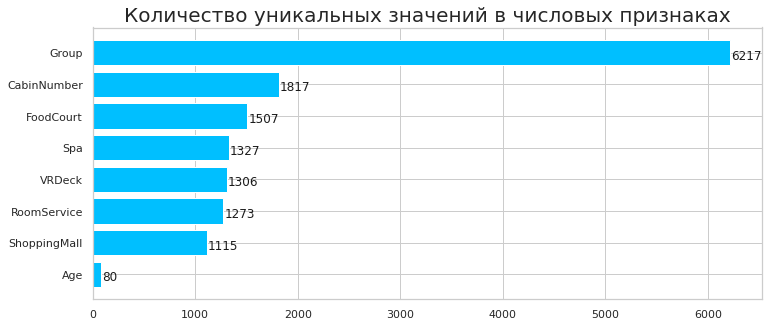

In [629]:
train_numeric_count = train_numeric.nunique().sort_values()
plt.figure(figsize=(12,5))
plt.barh(y=train_numeric_count.index, width=train_numeric_count.values, color=COLOR_PLOT)
plt.title('Количество уникальных значений в числовых признаках', fontsize=20)
for i, v in enumerate(train_numeric_count.values):
    plt.text(v+10, i - .2, str(v), color='k')

По графику делаем вывод, что категориальных нет среди численных, тк очень много различных значений

**Сформируем окончательные массивы с категориальными и численными признаками**

In [630]:
non_numeric_cols = [col for col in train.select_dtypes(exclude=[np.number]).columns.values if col != 'Transported']
numeric_cols = train.select_dtypes(include=[np.number]).columns.values


# Анализ категориальных переменных

## Распределение признаков

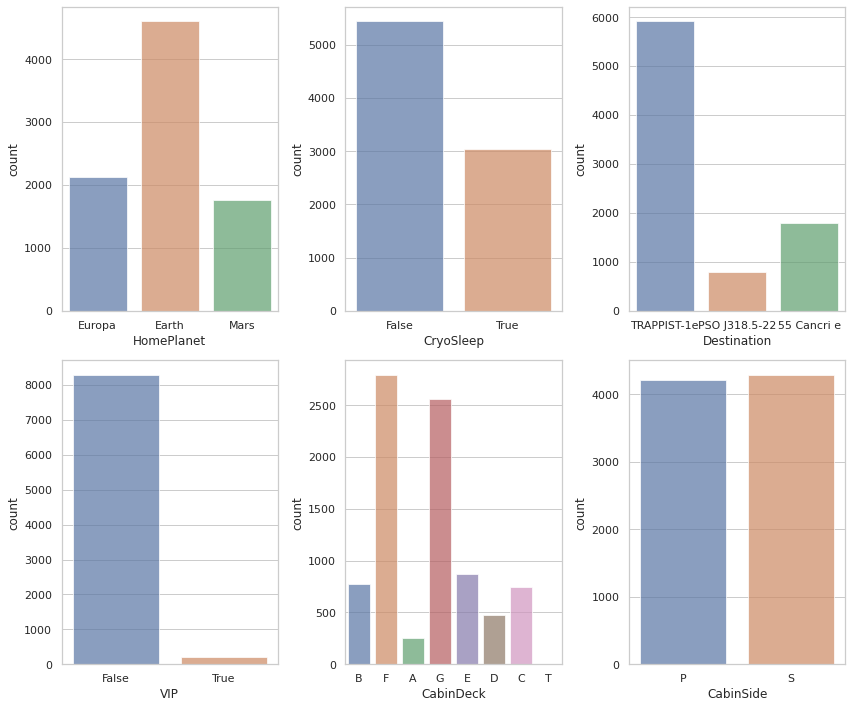

In [631]:
fig, axes = plt.subplots(ceil(len(non_numeric_cols)/3), 3, figsize=(12,10))
for y, col in enumerate(non_numeric_cols):
    i, j = divmod(y, 3)
    sns.countplot(data=train, x=col, alpha=0.7, ax=axes[i,j])
fig.tight_layout()

Видим, что признак VIP = 1 довольно редко, возможно, его нужно будет исключить из анализа, но прежде посмотрим как влияют разные значения категориальных признаков на целевой признак

Так же заметим, что CabinDeck значение T выбивается из алфавитного порядка, проверим кол-во значений его, а не выброс ли это?

In [632]:
train.CabinDeck.value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: CabinDeck, dtype: int64

Посмотрим в тестовой выборке

In [633]:
test.CabinDeck.value_counts()

F    1445
G    1222
E     447
B     362
C     355
D     242
A      98
T       6
Name: CabinDeck, dtype: int64

Значений T мало, но они имеются в тестовой выборке, потому отбрасывать не будем.

## Влияние признаков на целевую переменную

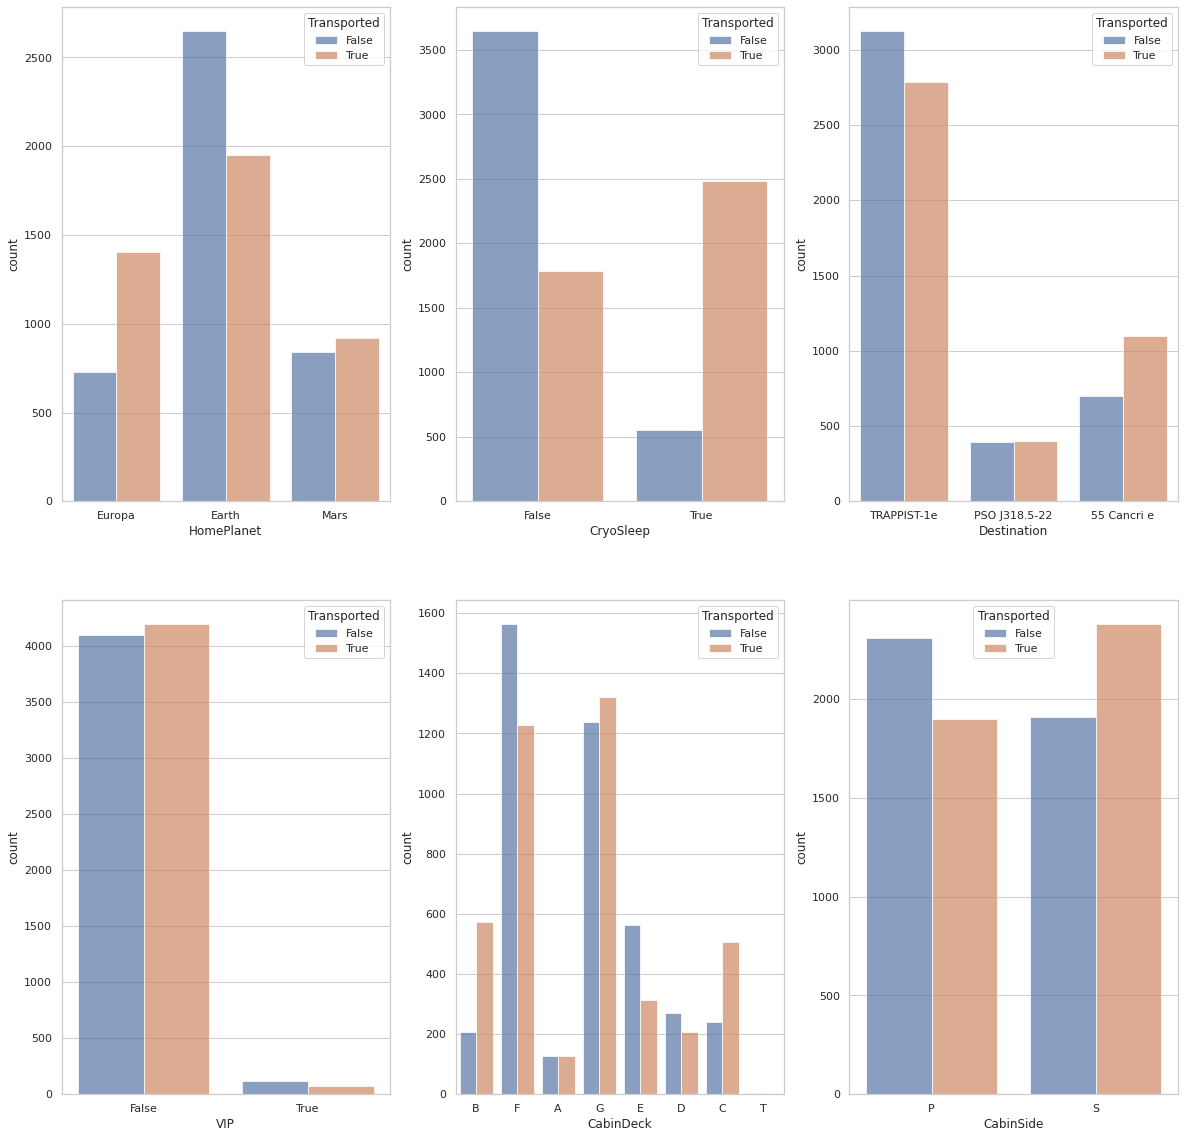

In [634]:
fig, axes = plt.subplots(ceil(len(non_numeric_cols)/3), 3, figsize=(20,20))
for y, col in enumerate(non_numeric_cols):
    i, j = divmod(y, 3)
    sns.countplot(data=train, x=col, hue='Transported', alpha=0.7, ax=axes[i,j])


По графикам можем сделать следующие выводы:
 + HomePlanet: для Earth больше шансов НЕ транспортироваться, в то время как для Europa - наоборот, а вот для марсиан шансы примерно равны
 + CryoSleep: большинство впавших в спячку были транспортированы, иначе - наоборот
 + Destination, VIP - по графикам не понятно на сколько значима разница, нужно провести χ² тест
 + CabinDeck и CabinSide разница визуально виднеется

Позже мы изучим влияние Destination на целевую, но прежде изучим отсутствующие данные

Задачи из графиков:
+ провести χ² тест влияния Destination на целевую
+ удалить признак VIP для минимизации переобучения в следствие слабого влияния на целевую и слабой вариативности

## Модификация признаков с NaN

Для начала рассмотрим какое количество пропущенных значений

In [635]:
# выведем колонки с пропущенными значениями
col_cat_sum_na = train[non_numeric_cols].isna().sum()
col_cat_with_na = col_cat_sum_na[col_cat_sum_na>0].index.to_list()
col_cat_with_na

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide']

In [636]:
# выведем количество пропущенных значений
train[col_cat_with_na].isna().sum()

HomePlanet     201
CryoSleep      217
Destination    182
VIP            203
CabinDeck      199
CabinSide      199
dtype: int64

Построим график процентого соотношения отсутствующих данных в данных колонках

Text(0, 0.5, 'Признак\n')

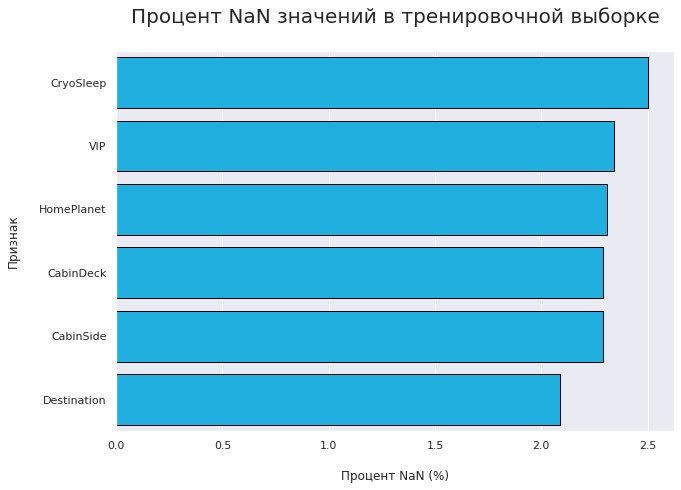

In [637]:
column_name = []
percent_nan = []
for i in col_cat_with_na:
    column_name.append(i)
    percent_nan.append(round(train[i].isna().sum()*100/len(train[i]), 2))
    
tab = pd.DataFrame({"Column": column_name, "Percent_NaN": percent_nan})
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)

sns.set(rc={"figure.figsize": (10, 7)})

p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="deepskyblue")
p.set_title("Процент NaN значений в тренировочной выборке\n", fontsize=20)
p.set_xlabel("\nПроцент NaN (%)")
p.set_ylabel("Признак\n")

Процент пропущенных значений не велик. Заменим их на моды

In [638]:
for col in col_cat_with_na:
    train[col] = train[col].fillna(train[col].mode().iloc[0])

In [639]:
#проверими, что нет отсутствующих значений
train[col_cat_with_na].isna().sum()

HomePlanet     0
CryoSleep      0
Destination    0
VIP            0
CabinDeck      0
CabinSide      0
dtype: int64

## Проверка зависимости целевой переменной 

**Проведем χ² тест для того, чтоб понять на сколько равномерно распределение целевого признака по значениям Destination, VIP**

In [640]:
cols = ['Destination', 'VIP']
for col in cols:
    CrosstabResult = pd.crosstab(index=train[col], columns=train['Transported'])
    ChiSqResult = chi2_contingency(CrosstabResult)
    print(
        f"P-Value χ² теста между группами {col} и Transported = {ChiSqResult[1]}\n")
    


P-Value χ² теста между группами Destination и Transported = 1.1947894351445014e-23

P-Value χ² теста между группами VIP и Transported = 0.0006681023600149099



Тест показал, что зависимость имеется, поэтому оставим данные признаки

## Взаимосвязь между признаками

Посмотрим на графиках, как связаны некоторые категориальные признаки друг с другом

**HomePlanet**

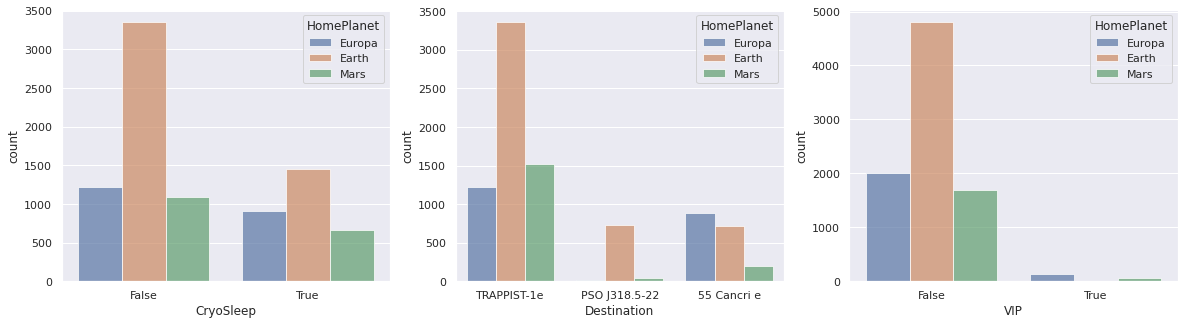

In [641]:
cols = ['CryoSleep', 'Destination', 'VIP']
fig, axes = plt.subplots(ncols=3, figsize=(20,5))
for y, col in enumerate(cols):
    sns.countplot(data=train, x=col, hue='HomePlanet', alpha=0.7, ax=axes[y])

Анализ данных графиков и графиков из п.5.1 показал, что КриоСон выбирают примерно одинаково независимо от родной планеты, а вот направления определенно зависят от HomePlanet, как и выбор VIP. Проведем χ² тест

In [642]:
X = ["HomePlanet", "HomePlanet"]
Y = ["Destination", "VIP"]
    
ksi(train, X, Y)

P-Value χ² теста между группами HomePlanet и Destination = 3.2783690516910283e-246

P-Value χ² теста между группами HomePlanet и VIP = 1.2320170249145718e-56



Тест показал, что распределение действительно неравномерно

**CryoSleep**

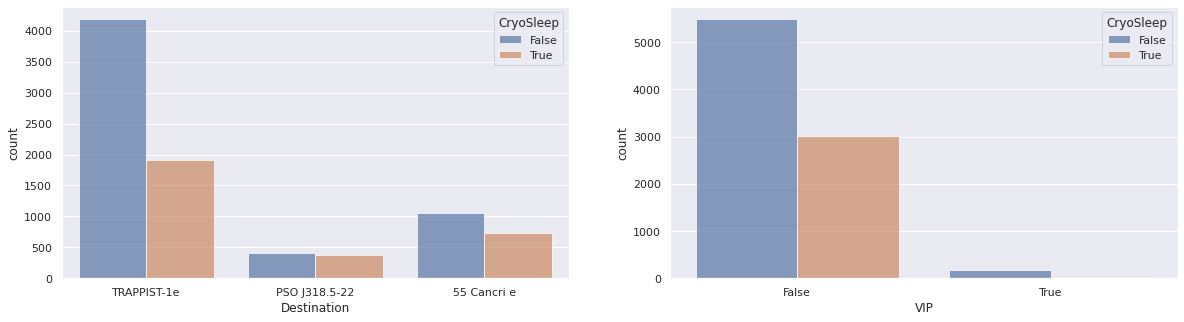

In [643]:
cols = ['Destination', 'VIP']
fig, axes = plt.subplots(ncols=2, figsize=(20,5))
for y, col in enumerate(cols):
    sns.countplot(data=train, x=col, hue='CryoSleep', alpha=0.7, ax=axes[y])

По графикам наблюдаем зависимость КриптоСна от приведенных признаков. Например, реже всего криптосон нвыбирают на направлении TRAPPIST-1e,  а чаще всего по напрвлению PSO J318.5-22, здесь соотвношение спящих к неспящим примерно 1 к 1. Так же интересно заметить, что VIP практически не выбирают КриптоСон (всего 21 таких наблюдений - 10,6% от всех VIP):

In [644]:
len(train[train.CryoSleep & train.VIP])/len(train[train.VIP])

0.10552763819095477

**Destination**


<AxesSubplot:xlabel='VIP', ylabel='count'>

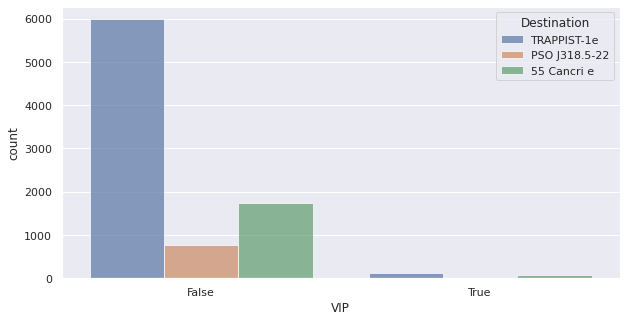

In [645]:
plt.figure(figsize=(10,5))
sns.countplot(data=train, x='VIP', hue='Destination', alpha=0.7)

По данному графику складывается впечатление, что эти признаки не обладают большой связью

##  Модификация тестовой выборки

In [646]:
# выведем колонки с пропущенными значениями
col_cat_sum_na = test[non_numeric_cols].isna().sum()
col_cat_with_na = col_cat_sum_na[col_cat_sum_na>0].index.to_list()
col_cat_with_na

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinSide']

In [647]:
# выведем количество пропущенных значений
test[col_cat_with_na].isna().sum()

HomePlanet      87
CryoSleep       93
Destination     92
VIP             93
CabinDeck      100
CabinSide      100
dtype: int64

Количество пропущенных значений невелико, произведем замену:

In [648]:
for col in col_cat_with_na:
    test[col] = test[col].fillna(test[col].mode().iloc[0])

In [649]:
#проверими, что нет отсутствующих значений
train[col_cat_with_na].isna().sum().sum()

0

Далее мы проведем кодировку категориальных признаков, тк в анализе числовых признаков мы будем заполнять пропущенные значения методами машинного обучения

## Кодирование категориальных признаков

In [650]:
#отбираем категориальные признаки
train_non_numeric = train.select_dtypes(exclude=[np.number])
non_numeric_cols = train_non_numeric.columns.values
print(non_numeric_cols)

['HomePlanet' 'CryoSleep' 'Destination' 'VIP' 'Transported' 'CabinDeck'
 'CabinSide']


чтобы преобразовать категориальные признаки к дамми-переменным, нужно для начала объединить тренировочную выборку с тестовой, чтоб не получилось так, что в одной одни колонки, в другой - другие. А после уже снова разбить на тренировочную и тестовую

In [651]:
#запоминаем длину тренировочной и целевую - чтобы потом их восстановить из объединенной
len_train = train.shape[0]
target = train.Transported

In [652]:
#объединяем
X_all = train[[col for col in train.columns if col != 'Transported']].append(test) 
X_all.shape

(12970, 14)

In [653]:
X_all = pd.get_dummies(X_all, columns=[col for col in non_numeric_cols if col != 'Transported'])
X_all.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,CabinNumber,HomePlanet_Earth,HomePlanet_Europa,...,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
0,39.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,1,...,0,1,0,0,0,0,0,0,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,2,0.0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,3,0.0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,3,0.0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,4,1.0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [654]:
#разделяем назад на тренировочную и тестовую выборки
train = X_all[:len_train]
test = X_all[len_train:]
train.loc[:, 'Transported'] = target.values
train.Transported.head()


/home/sonador/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


0    False
1     True
2    False
3    False
4     True
Name: Transported, dtype: bool

# Анализ числовых переменных

## Распределение признаков

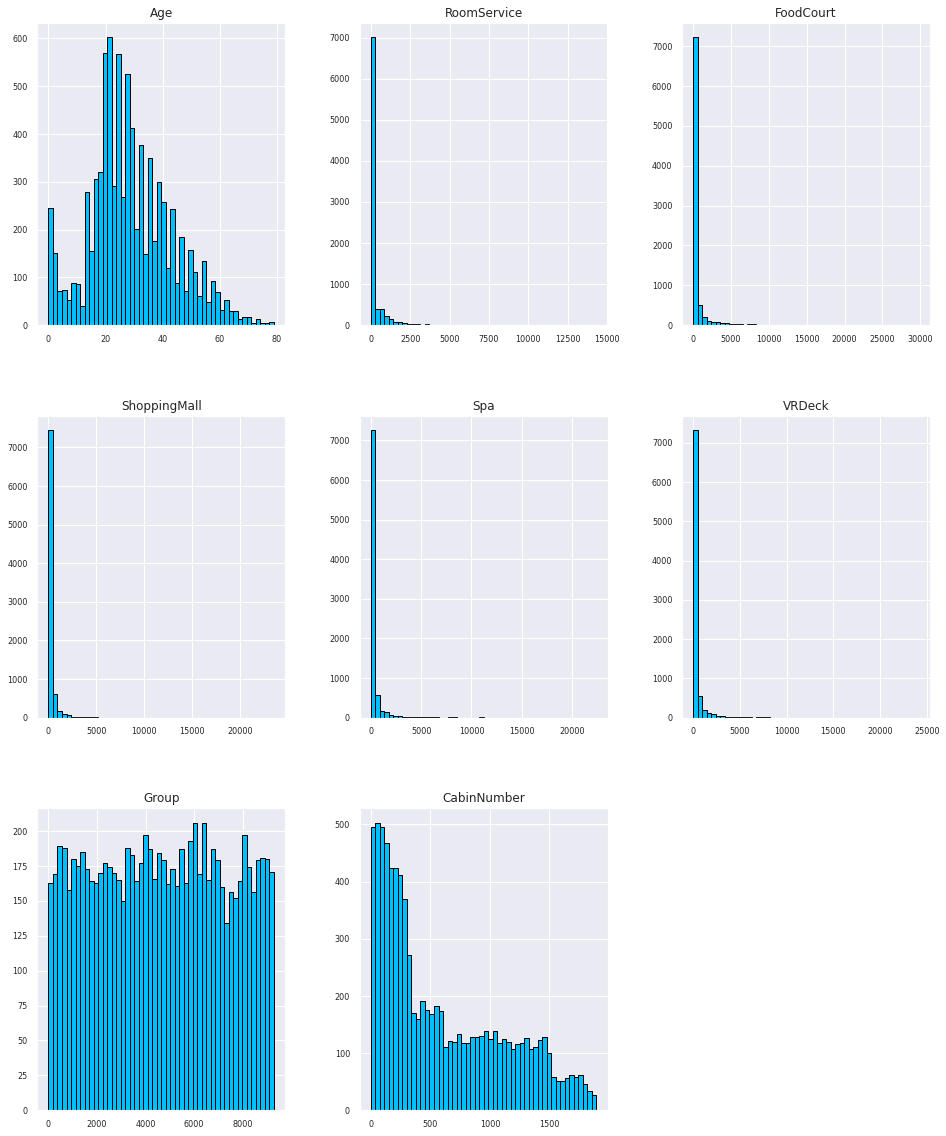

In [655]:
ig_ = train[numeric_cols].hist(figsize=(16, 20), bins=50, color=COLOR_PLOT,
                         edgecolor="black", xlabelsize=8, ylabelsize=8)

По графикам видим, что большинство признаков распределены логонормально, а признак Group - практически равномерно

Посмотрим на описательные статистики

In [656]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,CabinNumber,HomePlanet_Earth,HomePlanet_Europa,...,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8494.000000,8693.000000,8693.000000,...,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,4633.389624,600.367671,0.552514,0.245140,...,0.029449,0.089612,0.085931,0.054987,0.100771,0.344300,0.294375,0.000575,0.483838,0.516162
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,2671.028856,511.867226,0.497263,0.430195,...,0.169071,0.285642,0.280279,0.227968,0.301042,0.475167,0.455787,0.023977,0.499767,0.499767
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2319.000000,167.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4630.000000,427.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,6883.000000,999.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,9280.000000,1894.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


видим, что большинство пассажиров - молодые люди (75% - до 38 лет), большинство людей не пользуются дополнительными услугами. Так же интересно заметить, что верхние значения доп услуг во много раз выше 75% Квантиля - нужно изучить их на вопрос выбросов

## Работа с выбросами

Посмотрим на значения выше 75% квантиля

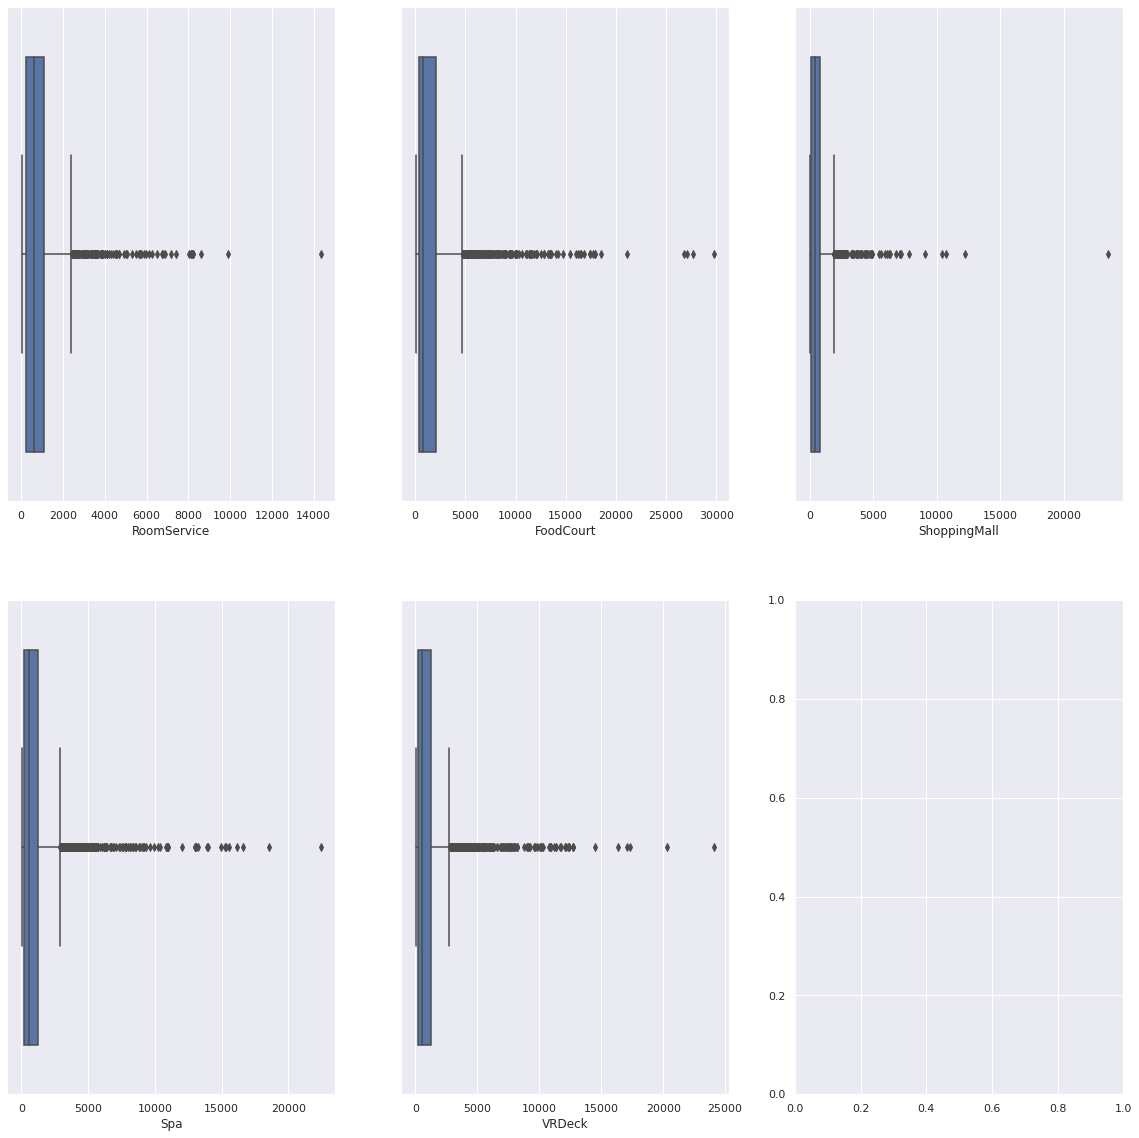

In [657]:
col_for_research = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
fig, axes = plt.subplots(ceil(len(col_for_research)/3), 3, figsize=(20,20))
for y, col in enumerate(col_for_research):
    i, j = divmod(y, 3)
    data = train[train[col] > train[col].quantile(q=0.75)]
    sns.boxplot(data=data, x=col, ax=axes[i,j])


По графикам видим несколько экстремально высоких значений, удалим их, чтобы не вносили шум в наши данные

In [658]:
outliers1 = train[train["RoomService"] > 9000].index.to_list()
outliers1

[4416, 5105]

In [659]:
outliers2 = train[train["FoodCourt"] > 20000].index.to_list()
outliers2

[1213, 1842, 2067, 3198, 3538]

In [660]:
outliers3 = train[train["ShoppingMall"] > 15000].index.to_list()
outliers3

[8415]

In [661]:
outliers4 = train[train["Spa"] > 17500].index.to_list()
outliers4

[5722, 7995]

In [662]:
outliers5 = train[train["VRDeck"] > 14000].index.to_list()
outliers5

[725, 3366, 3916, 4311, 5619, 6547]

In [663]:
#объединяем в один массив индексы, замечаем, что есть прям явные отклонения сразу по нескольким признакам
outliers = list(set(outliers1 + outliers2 + outliers3 +outliers4 + outliers5))
train.shape

(8693, 29)

In [664]:
# удаляем выбросы
train = train.drop(outliers)
train.shape

(8677, 29)

## Влияние признаков на целевую переменную

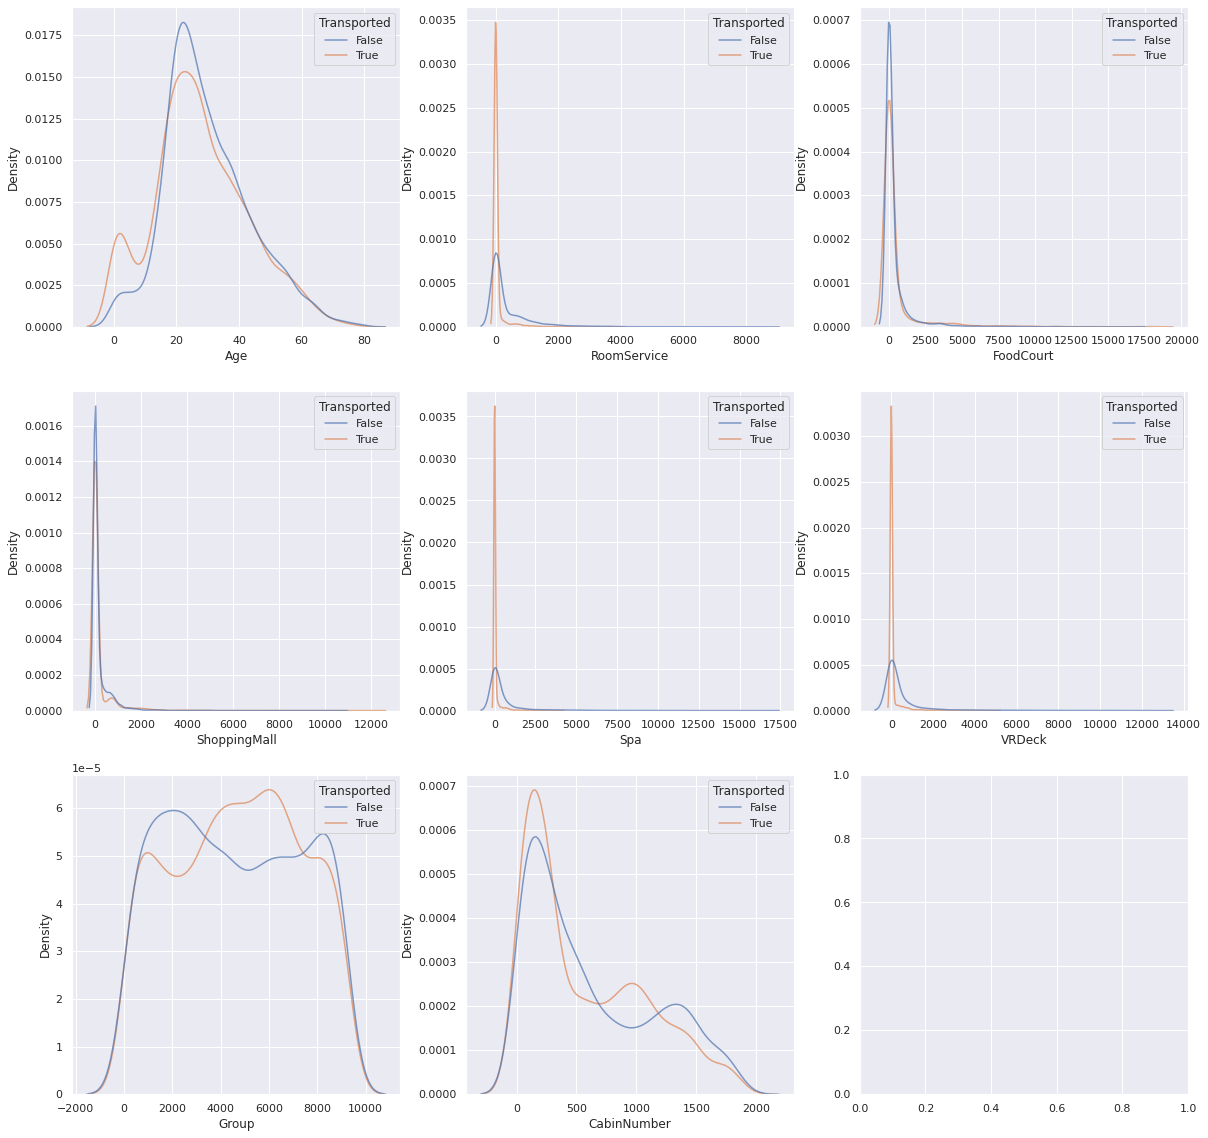

In [665]:
fig, axes = plt.subplots(ceil(len(numeric_cols)/3), 3, figsize=(20,20))
for y, col in enumerate(numeric_cols):
    i, j = divmod(y, 3)
    sns.kdeplot(data=train, x=col, hue='Transported', alpha=0.7, ax=axes[i,j])
    

Можно сделать несколько интересных выводов: 
+ шансы быть транспортированными для молодых до 18 лет выше, чем нет, с 18 до 40 лет шансы быть не транспортированным выше, старше 40 лет - шансы равны
+ Распределение доп трат напоминает экспоненциальное
+ если вы тратите на RoomService, то шансы быть транспортированными уменьшаются, аналогично для Spa и VRDeck
+ сам номер группы маловероятно, что влияет на целевую, зато из него можно вынести полезные признаки такие как: размер группы

Задачи из выводов:
+ ввести новый признак, определяющий категорию возрастную: ребенок, взрослый, старший(>40 лет)
+ ввести новый признак - тратит или нет пассажир на доп услуги (бинарный)
+ ввести новый признак - сумму , затраченную на все доп.услуги
+ к признакам доп услуг применить лог-преобразование 
+ ввести новый признак - размер группы
+ признак CabinNumber можно попробовать разбить на группы - в разных участках по разному влияние на целевую
+ так же, как и с группами, можно посмотреть сколько человек едут с пассажиром в одной кабине - влияет или нет на целевую

In [666]:
#col_for_del = ['Group', 'CabinNumber']
#train = train.drop(col_for_del, axis=1)
#test = test.drop(col_for_del, axis=1)

In [667]:
#и удалить из массива с целочисленными столбцами
#numeric_cols = del_from_list(numeric_cols, col_for_del)

## Модификация признаков с NaN

In [668]:
# выведем колонки с пропущенными значениями
col_int_sum_na = train[numeric_cols].isna().sum()
col_int_with_na = col_int_sum_na[col_int_sum_na>0].index.to_list()
col_int_with_na

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'CabinNumber']

In [669]:
train[col_int_with_na].isna().sum()

Age             179
RoomService     180
FoodCourt       183
ShoppingMall    208
Spa             182
VRDeck          188
CabinNumber     198
dtype: int64

Процент пропущенных значений во всех признаках не велик(<<10%). 

Попробуем предсказать пропущенные значения при помощи дерева решений, поэтому прежде нам пришлось закодировать категориальные признаки

In [670]:
# выбираем колонки, которые будем заполнять
col_with_na = train[col_int_with_na].isna().sum()[train[col_int_with_na].isna().sum() > 0].index.to_list()
# колонки , по которым будем предсказывать
col_for_predict = [col for col in train.columns if col not in col_with_na and col != 'Transported']

for col in col_with_na: 
    data_na = train[train[col].isna()]
    X_pred = data_na[col_for_predict]
    
    data_pred = train[train[col].notna()]
    X = data_pred[col_for_predict]
    y = data_pred[col]
    
    regressor = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=5)
    regressor.fit(X, y)
    y_pred = regressor.predict(X_pred)
    train.loc[train[col].isna(), col] = y_pred
    
    #DecisionTreeRegressor
    #print(col,':', y_pred)

In [671]:
#проверим, что не осталось пустых значений
train.isna().sum().sum()

0

Проверим новые распределения наших числовых признаков

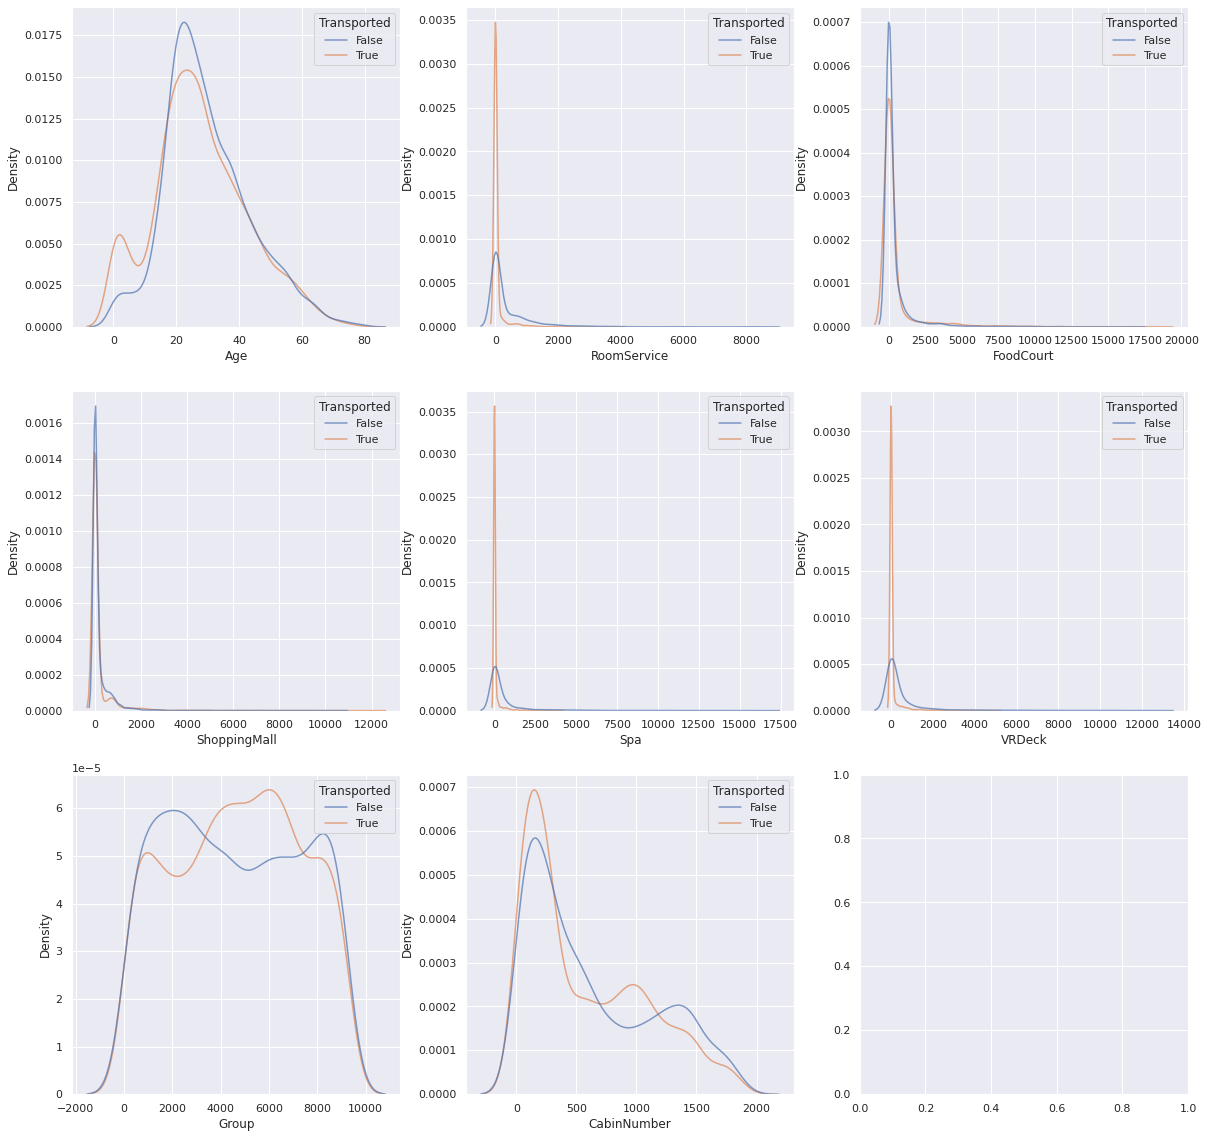

In [672]:
fig, axes = plt.subplots(ceil(len(numeric_cols)/3), 3, figsize=(20,20))
for y, col in enumerate(numeric_cols):
    i, j = divmod(y, 3)
    sns.kdeplot(data=train, x=col, hue='Transported', alpha=0.7, ax=axes[i,j])
    

Распределения после модификации пустых значений выглядят похоже с изначальными.

**Теперь модифицируем NaN в тестовой выборке**

In [673]:
test[col_int_with_na].isna().sum()

Age              91
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
CabinNumber     100
dtype: int64

Процент пропущенных значений во всех признаках не велик(<<10%).

Заполним пропущенные в тестовой при помощи дерева решений

In [674]:
# выбираем колонки, которые будем заполнять
col_with_na = test[col_int_with_na].isna().sum()[test[col_int_with_na].isna().sum() > 0].index.to_list()
# колонки , по которым будем предсказывать
col_for_predict = [col for col in test.columns if col not in col_with_na]

for col in col_with_na: 
    data_na = test[test[col].isna()]
    X_pred = data_na[col_for_predict]
    
    data_pred = test[test[col].notna()]
    X = data_pred[col_for_predict]
    y = data_pred[col]
    
    regressor = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=5)
    regressor.fit(X, y)
    y_pred = regressor.predict(X_pred)
    test.loc[test[col].isna(), col] = y_pred

/home/sonador/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/sonador/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/sonador/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [675]:
test.isna().sum().sum()

0

Мы заполнили все пропущенные значения в тестовой выборке

## Корреляционный анализ

<AxesSubplot:>

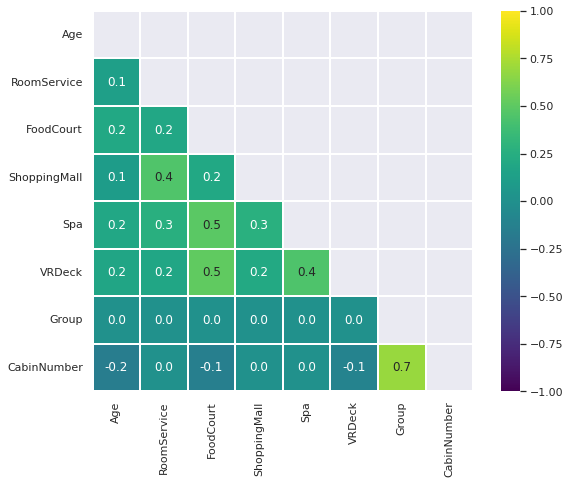

In [676]:
train_num_corr = train[numeric_cols]
#признаки распределены не нормально, поэтому используем непараметрическую корреляцию Спирмана
corr_matrix = train_num_corr.corr(method='spearman')
#для лучшей визуализации обнуляем корреляции, которые ниже заданного порога
corr_matrix[abs(corr_matrix) <= TRESHOLD_FOR_CORR] = 0
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = "viridis"

sns.heatmap(corr_matrix,  mask=mask, linewidths=0.1, vmax=1.0, vmin=-1.0,  square=True, cmap=cmap, 
            annot=True, fmt=".1f")

По карте корреляции видим, что самая сильная положительная корреляция между группой и номерм кабины, что логично: люди из одной группы чаще выбирают одну кабину. Так же ощутимая корреляция между FoodCourt и VRDeck, Spa. Кореляция хоть и есть, но не критичная (ниже нашего порогового значения, определенного в п.2.2), поэтому исследованные численные признаки из анализа мы удалять пока не будем

# Feature engineering

**Введем признак Age status, используя данные с п.6.3**

/tmp/ipykernel_2214/4018633191.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['AgeStatus'] = np.nan
/home/sonador/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/sonador/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

Text(0.5, 1.0, 'Влияние на целевую AgeStatus')

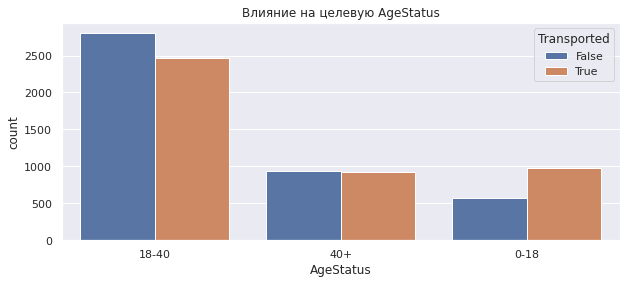

In [677]:
train['AgeStatus'] = np.nan
train.loc[train.Age<18, 'AgeStatus'] = '0-18'
train.loc[(train.Age<40) & (train.Age>=18), 'AgeStatus'] = '18-40'
train.AgeStatus.fillna('40+', inplace=True)

test['AgeStatus'] = np.nan
test.loc[test.Age<18, 'AgeStatus'] = '0-18'
test.loc[(test.Age<40) & (test.Age>=18), 'AgeStatus'] = '18-40'
test.AgeStatus.fillna('40+', inplace=True)


plt.figure(figsize=(10,4))
g=sns.countplot(data=train, x='AgeStatus', hue='Transported')
plt.title('Влияние на целевую AgeStatus')

Группа людей до 18 лет с большей доли вероятности будет транспортирована, для группы старше 40 ситуация обратная

 **Дополнительные траты - есть они у пассажира или нет (признак SpendExtraService), а так же общая сумма SumExtraService**

In [678]:
col_extra_service = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
 
train['SumExtraService'] = train[col_extra_service].sum(axis=1)
train['SpendExtraService'] = (train['SumExtraService']>0).astype(int)

test['SumExtraService'] = test[col_extra_service].sum(axis=1)
test['SpendExtraService'] = (test['SumExtraService']>0).astype(int)

train.head()

/tmp/ipykernel_2214/3096368247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SumExtraService'] = test[col_extra_service].sum(axis=1)
/tmp/ipykernel_2214/3096368247.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SpendExtraService'] = (test['SumExtraService']>0).astype(int)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,CabinNumber,HomePlanet_Earth,HomePlanet_Europa,...,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S,Transported,AgeStatus,SumExtraService,SpendExtraService
0,39.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,1,...,0,0,0,0,1,0,False,18-40,0.0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,2,0.0,1,0,...,0,1,0,0,0,1,True,18-40,736.0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,3,0.0,0,1,...,0,0,0,0,0,1,False,40+,10383.0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,3,0.0,0,1,...,0,0,0,0,0,1,False,18-40,5176.0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,4,1.0,1,0,...,0,1,0,0,0,1,True,0-18,1091.0,1


Text(0.5, 1.0, 'Есть доп. траты или нет')

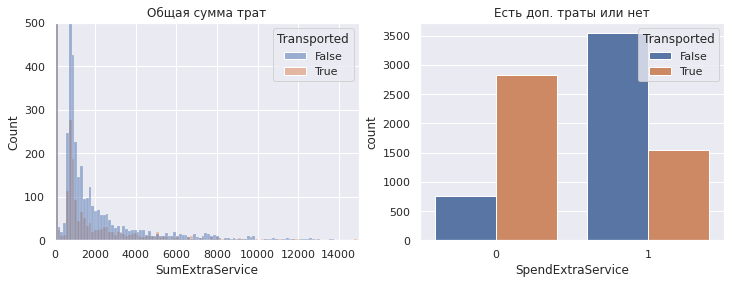

In [679]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(data=train, x='SumExtraService', hue='Transported', ax=axes[0], bins=200)
axes[0].set_title('Общая сумма трат')
axes[0].set_xlim(0, 15000)
axes[0].set_ylim(0, 500)

sns.countplot(data=train, x='SpendExtraService', hue='Transported', ax=axes[1])
axes[1].set_title('Есть доп. траты или нет')

Еще раз убеждаемся, что если пассажир тратит на доп. услуги - его шансы быть транспортировавшимся уменьшаются

**Группа пассажиров**

Попробуем ввести новый признак - число человек в группе, и посмотрим как это влияет на целевую

In [680]:
train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,CabinNumber,HomePlanet_Earth,HomePlanet_Europa,...,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S,Transported,AgeStatus,SumExtraService,SpendExtraService
0,39.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0,1,...,0,0,0,0,1,0,False,18-40,0.0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,2,0.0,1,0,...,0,1,0,0,0,1,True,18-40,736.0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,3,0.0,0,1,...,0,0,0,0,0,1,False,40+,10383.0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,3,0.0,0,1,...,0,0,0,0,0,1,False,18-40,5176.0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,4,1.0,1,0,...,0,1,0,0,0,1,True,0-18,1091.0,1


Проверим, что группы тестовой и тренировочной отличаются:

In [681]:
gr_tr = train.Group.unique()
gr_ts = test.Group.unique()
per = np.intersect1d(gr_tr, gr_ts)
per

array([], dtype=int16)

пустое пересечение нам говорит о том, что группы тестовой никак не связаны с тренировочной и мы модем анализировать численность пассажиров в них отдельно

In [682]:
num_in_gr_train = train.Group.value_counts()
train['NumGroup'] = train.Group.apply(lambda x: num_in_gr_train[x])

num_in_gr_test = test.Group.value_counts()
test['NumGroup'] = test.Group.apply(lambda x: num_in_gr_test[x])

train.tail()


/tmp/ipykernel_2214/2296545240.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['NumGroup'] = test.Group.apply(lambda x: num_in_gr_test[x])


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,CabinNumber,HomePlanet_Earth,HomePlanet_Europa,...,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S,Transported,AgeStatus,SumExtraService,SpendExtraService,NumGroup
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,9276,98.0,0,1,...,0,0,0,1,0,False,40+,8536.0,1,1
8689,18.0,0.0,0.0,0.0,0.0,0.0,9278,1499.0,1,0,...,0,1,0,0,1,False,18-40,0.0,0,1
8690,26.0,0.0,0.0,1872.0,1.0,0.0,9279,1500.0,1,0,...,0,1,0,0,1,True,18-40,1873.0,1,1
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,9280,608.0,0,1,...,0,0,0,0,1,False,18-40,4637.0,1,2
8692,44.0,126.0,4688.0,0.0,0.0,12.0,9280,608.0,0,1,...,0,0,0,0,1,True,40+,4826.0,1,2


Text(0.5, 1.0, 'Влияние размера группы на целевую')

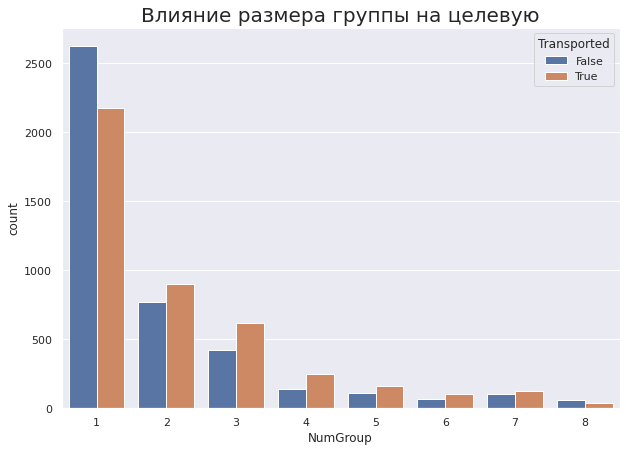

In [683]:
sns.countplot(data=train, x='NumGroup', hue='Transported')
plt.title('Влияние размера группы на целевую', fontsize=20)

По графику отмечаем тот факт, что если человек путешествует один, то шансов быть транспортированным меньше, если путешествует в компании - то наоборот. Чтобы не порождать много признаков, каждый для своей группы, попробуем ввести признак, отвечающий один путешествует или нет:

In [684]:
train['Along'] = (train.NumGroup == 1).astype(int)

<AxesSubplot:xlabel='Along', ylabel='count'>

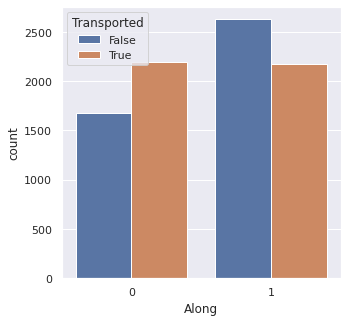

In [685]:
plt.figure(figsize=(5,5))
sns.countplot(data=train, x='Along', hue='Transported')


Проведем необходимые изменения в тренировочной выборке и удалим промежуточные признаки

In [686]:
test['Along'] = (test.NumGroup == 1).astype(int)
train.drop(['NumGroup','Group'], axis=1, inplace=True)
test.drop(['NumGroup','Group'], axis=1, inplace=True)
numeric_cols = del_from_list(numeric_cols, ['Group'])

/tmp/ipykernel_2214/2406592231.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Along'] = (test.NumGroup == 1).astype(int)
/home/sonador/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


**Теперь изучим признак номер кабины CabinNumber**

Text(0.5, 1.0, 'Влияние номера кабины на целевую')

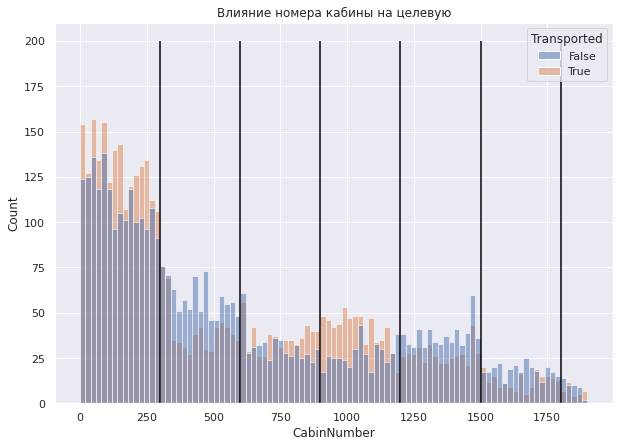

In [687]:
sns.histplot(data=train, x='CabinNumber', hue='Transported', binwidth=20)
step=300
for i in range(6):
    x_coord = (i+1)*step
    plt.vlines(x_coord, ymin=0, ymax=200, color='black')
plt.title('Влияние номера кабины на целевую')

Интересно заметить, что мы можем разбить номера групп на чанки, в каждом влияние на целевую проявляется по своему

In [688]:
cat = [-1, 300, 600, 900, 1200, 1500, 1800, 2000]
train['CategoryCabinNumber'] = pd.cut(train.CabinNumber, cat, labels=range(7))
train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNumber,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S,Transported,AgeStatus,SumExtraService,SpendExtraService,Along,CategoryCabinNumber
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,0,0,1,0,False,18-40,0.0,0,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,0.0,1,0,0,...,0,0,0,1,True,18-40,736.0,1,1,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0,1,0,...,0,0,0,1,False,40+,10383.0,1,0,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0,1,0,...,0,0,0,1,False,18-40,5176.0,1,0,0
4,16.0,303.0,70.0,151.0,565.0,2.0,1.0,1,0,0,...,0,0,0,1,True,0-18,1091.0,1,1,0


Проделаем эти же изменения, только с тестовой выборкой, но прежде убедимся, что ее максимальное значение не выходит за вышеобозначенные рамки:

In [689]:
test.CabinNumber.max()

1890.0

In [690]:
test['CategoryCabinNumber'] = pd.cut(test.CabinNumber, cat, labels=range(7))

/tmp/ipykernel_2214/429422405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['CategoryCabinNumber'] = pd.cut(test.CabinNumber, cat, labels=range(7))


**На последок посмотрим влияние количества пассажиров в кабине на целевую**

Для этого нам нужно прежде вернуть колонку Deck и side

In [691]:
train['Deck'] = train['CabinDeck_A']*1 + train['CabinDeck_B']*2 + train['CabinDeck_C']*3 + train['CabinDeck_D']*4 +\
    train['CabinDeck_E']*5 + train['CabinDeck_F']*6 + train['CabinDeck_G']*7 + train['CabinDeck_T']*8

train['Side'] = train['CabinSide_P']*1 + train['CabinSide_S']*2 


теперь считаем сколько пассажиров едут в одной кабине

In [692]:
num_cabin = train.groupby(['Deck', 'Side', 'CabinNumber']).SumExtraService.count()

In [693]:
#train['CountCabin'] = num_cabin[train.Deck][train.Side][train.CabinNumber]
train['CountCabin'] = train.apply(lambda x: num_cabin[x.Deck][x.Side][x.CabinNumber], axis=1)
train.tail()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNumber,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,CabinSide_S,Transported,AgeStatus,SumExtraService,SpendExtraService,Along,CategoryCabinNumber,Deck,Side,CountCabin
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,98.0,0,1,0,...,0,False,40+,8536.0,1,1,0,1,1,1
8689,18.0,0.0,0.0,0.0,0.0,0.0,1499.0,1,0,0,...,1,False,18-40,0.0,0,1,4,7,2,1
8690,26.0,0.0,0.0,1872.0,1.0,0.0,1500.0,1,0,0,...,1,True,18-40,1873.0,1,1,4,7,2,1
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,608.0,0,1,0,...,1,False,18-40,4637.0,1,0,2,5,2,2
8692,44.0,126.0,4688.0,0.0,0.0,12.0,608.0,0,1,0,...,1,True,40+,4826.0,1,0,2,5,2,2


<AxesSubplot:xlabel='CountCabin', ylabel='count'>

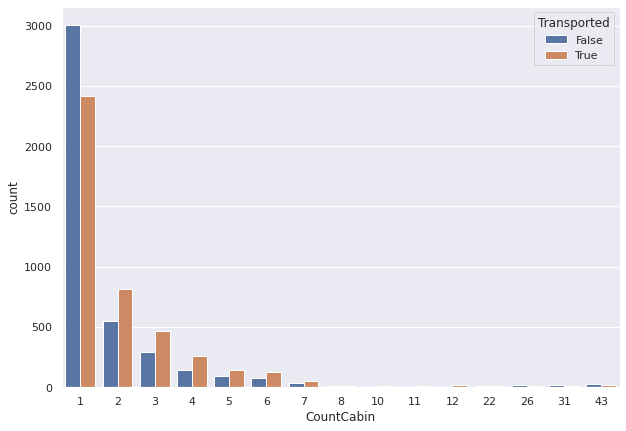

In [694]:
sns.countplot(data=train, x='CountCabin', hue='Transported')

Наблюдаем аналогичную картину, как и с Группами - если пассажир один в каюте, то шансы трансформироваться меньше

<AxesSubplot:xlabel='Along', ylabel='count'>

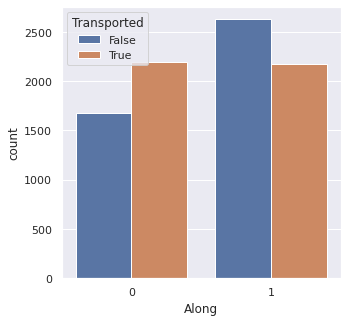

In [695]:
train['AlongInCabin'] = (train.CountCabin == 1).astype(int)
plt.figure(figsize=(5,5))
sns.countplot(data=train, x='Along', hue='Transported')

Проверим а всегда ли одиночки путешествуют одни в кабине (если да, то признаки Along и AlongInCabin сильно коррелируют и нужно оставить только один) - посчитаем процент отличающихся значений

In [696]:
print('Процент одиночек, путешествующих не в одиночку в кабине, а так же не одиночек, но одних в кабине: ', round(100*sum(abs(train['Along'] - train['AlongInCabin']))/train.shape[0],1), '%')

Процент одиночек, путешествующих не в одиночку в кабине, а так же не одиночек, но одних в кабине:  9.4 %


Процент не велик, да и по графикам видим, что распределение влияния на целевую очень похоже, чтобы избежать переобучения, последний признак не будем включать в анализ.

**удалим все промежуточные признаки и модифицируем массив с числовыми и категориальными колонками**

In [697]:
train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNumber,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Transported,AgeStatus,SumExtraService,SpendExtraService,Along,CategoryCabinNumber,Deck,Side,CountCabin,AlongInCabin
0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,False,18-40,0.0,0,1,0,2,1,1,1
1,24.0,109.0,9.0,25.0,549.0,44.0,0.0,1,0,0,...,True,18-40,736.0,1,1,0,6,2,1,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0.0,0,1,0,...,False,40+,10383.0,1,0,0,1,2,2,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0.0,0,1,0,...,False,18-40,5176.0,1,0,0,1,2,2,0
4,16.0,303.0,70.0,151.0,565.0,2.0,1.0,1,0,0,...,True,0-18,1091.0,1,1,0,6,2,1,1


In [750]:
col_for_add_num = ['SumExtraService']
#должны так же сохранить новые категориальные колонки, тк их нужно будет кодировать
#col_for_add_cat = ['AgeStatus', 'CategoryCabinNumber', 'SpendExtraService', 'Along']
col_for_add_cat = ['AgeStatus', 'CategoryCabinNumber', 'Along']
#col_for_add_cat = ['CategoryCabinNumber', 'SpendExtraService', 'Along']
numeric_cols = add_into_list(numeric_cols, col_for_add_num)

In [699]:
train.drop(['Deck', 'Side', 'CountCabin', 'AlongInCabin'], axis=1, inplace=True)

In [700]:
test.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNumber,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S,AgeStatus,SumExtraService,SpendExtraService,Along,CategoryCabinNumber
0,27.0,0.0,0.0,0.0,0.0,0.0,3.0,1,0,0,...,0,1,0,0,1,18-40,0.0,0,1,0
1,19.0,0.0,9.0,0.0,2823.0,0.0,4.0,1,0,0,...,1,0,0,0,1,18-40,2832.0,1,1,0
2,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,0,0,0,0,1,18-40,0.0,0,1,0
3,38.0,0.0,6652.0,0.0,181.0,585.0,1.0,0,1,0,...,0,0,0,0,1,18-40,7418.0,1,1,0
4,20.0,10.0,0.0,635.0,0.0,0.0,5.0,1,0,0,...,1,0,0,0,1,18-40,645.0,1,1,0


# Подготовка данных к моделированию

## Разделение тренировочной выборки на признаки и целевую переменную

In [786]:
X_train = train.drop(columns=['Transported'], axis=1).copy()
y_train = train['Transported'].copy()

X_test = test.copy()

test.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNumber,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S,AgeStatus,SumExtraService,SpendExtraService,Along,CategoryCabinNumber
0,27.0,0.0,0.0,0.0,0.0,0.0,3.0,1,0,0,...,0,1,0,0,1,18-40,0.0,0,1,0
1,19.0,0.0,9.0,0.0,2823.0,0.0,4.0,1,0,0,...,1,0,0,0,1,18-40,2832.0,1,1,0
2,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,0,0,0,0,1,18-40,0.0,0,1,0
3,38.0,0.0,6652.0,0.0,181.0,585.0,1.0,0,1,0,...,0,0,0,0,1,18-40,7418.0,1,1,0
4,20.0,10.0,0.0,635.0,0.0,0.0,5.0,1,0,0,...,1,0,0,0,1,18-40,645.0,1,1,0


## Удаление признаков

Здесь мы будем удалять некоторые признаки, которые могут мешать обучению модели всвязи с высокой корреляцией с другими признаками, и смотреть, как реагирует модель

В частности, нам в процессе построения моделей пришлось исключить наши новые признаки SumExtraService и SpendExtraService, тк с ними модель показывала результат хуже. Думаю, это связано с высокой корреляцией этих признаков с признаками доп.трат

In [787]:
X_test.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNumber,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S,AgeStatus,SumExtraService,SpendExtraService,Along,CategoryCabinNumber
0,27.0,0.0,0.0,0.0,0.0,0.0,3.0,1,0,0,...,0,1,0,0,1,18-40,0.0,0,1,0
1,19.0,0.0,9.0,0.0,2823.0,0.0,4.0,1,0,0,...,1,0,0,0,1,18-40,2832.0,1,1,0
2,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,...,0,0,0,0,1,18-40,0.0,0,1,0
3,38.0,0.0,6652.0,0.0,181.0,585.0,1.0,0,1,0,...,0,0,0,0,1,18-40,7418.0,1,1,0
4,20.0,10.0,0.0,635.0,0.0,0.0,5.0,1,0,0,...,1,0,0,0,1,18-40,645.0,1,1,0


In [788]:
col_for_del = ['Age', 'CabinNumber', 'SumExtraService', 'SpendExtraService']
X_train = X_train.drop(col_for_del, axis=1)
X_test = X_test.drop(col_for_del, axis=1)

In [789]:
numeric_cols = del_from_list(numeric_cols, col_for_del)
numeric_cols

array(['FoodCourt', 'RoomService', 'ShoppingMall', 'Spa', 'VRDeck'],
      dtype=object)

In [790]:
print('количество пропущенных значений в тренировочной:', X_train.isna().sum().sum())
print('количество пропущенных значений в тестовой:', test.isna().sum().sum())

количество пропущенных значений в тренировочной: 0
количество пропущенных значений в тестовой: 0


## Лог-трансформация признаков

В п.6.1. мы видели, что многие признаки распределены экспоненциально, попробуем выполнить лог преобразование и посмотреть на графиках как поменяется их распределение

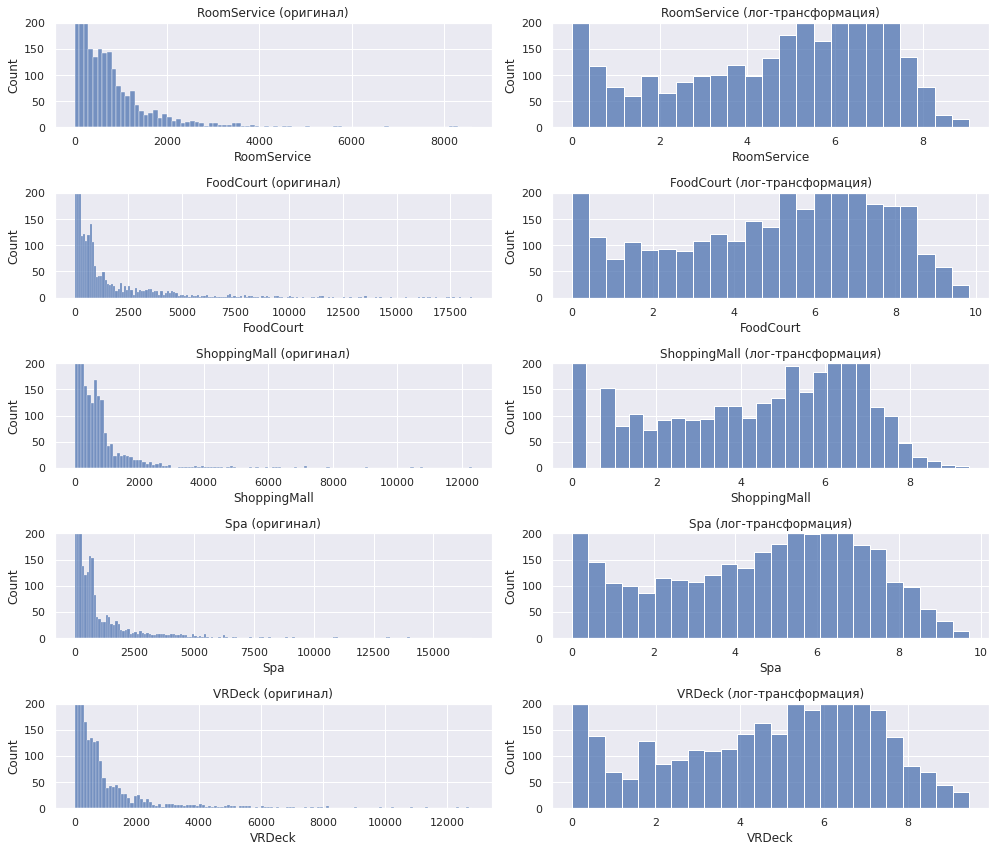

In [785]:
#col_log = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'SumExtraService']
col_log = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

sns.set(rc={"figure.figsize": (14, 12)})
fig, axes = plt.subplots(len(col_log), 2)

for i, col in enumerate(col_log):
    sns.histplot(X_train[col], ax=axes[i, 0], binwidth=100)
    axes[i,0].set_ylim([0,200])
    axes[i,0].set_title(f'{col} (оригинал)')
    
    sns.histplot(np.log(X_train[col]+1), ax=axes[i, 1])
    axes[i,1].set_ylim([0,200])
    axes[i,1].set_title(f'{col} (лог-трансформация)')
    
fig.tight_layout()

Применяем лог-трансформацию 
------ОТМЕНЕНО, те модели работают хуже! - скорее всего это связано с большим количесвтом 0 значений - распределение не нормальное---------

In [769]:
"""
for col in col_log:
    X_train[col] = np.log( X_train[col] + 1)
    X_test[col] = np.log( X_test[col] + 1)
    """

## Нормализация числовых признаков

In [791]:
X_train[numeric_cols].head()

,FoodCourt,RoomService,ShoppingMall,Spa,VRDeck
0,0.0,0.0,0.0,0.0,0.0
1,9.0,109.0,25.0,549.0,44.0
2,3576.0,43.0,0.0,6715.0,49.0
3,1283.0,0.0,371.0,3329.0,193.0
4,70.0,303.0,151.0,565.0,2.0


In [792]:
sc = StandardScaler()

X_train[numeric_cols] = sc.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = sc.transform(X_test[numeric_cols])
X_train[numeric_cols].head()

,FoodCourt,RoomService,ShoppingMall,Spa,VRDeck
0,-0.300196,-0.349156,-0.313714,-0.281719,-0.283144
1,-0.294010,-0.177644,-0.267725,0.224956,-0.240167
2,2.157505,-0.281495,-0.313714,5.915581,-0.235283
3,0.581580,-0.349156,0.368760,2.790629,-0.094631
4,-0.252086,0.127617,-0.035941,0.239722,-0.281190


## Кодирование Категориальных признаков

В п.5.7 мы уже проводили кодирование категориальных признаков, тк нам требовалось построить модель дерева решений для предсказания пропущенных значений, теперь нам осталось закодировать наши новые признаки, которые мы получили в п.7

In [793]:
col_for_add_cat

['AgeStatus', 'CategoryCabinNumber', 'Along']

Из новых категориальных признаков нам достаочно закодировать только два: 'AgeStatus', 'CategoryCabinNumber', т.к. остальные принимают значения 0 либо 1. Сверим, что в тренировочной и тестовой выборках одни встречаются одинакове значения этих признаков:

In [794]:
#print('Значения возрастных категорий тренир.выборки: ', X_train.AgeStatus.unique())
#print('Значения возрастных категорий тестовой.выборки: ', X_test.AgeStatus.unique())
print('Значения категорий кабин тренир.выборки: ', X_train.CategoryCabinNumber.unique())
print('Значения категорий кабин тестовой.выборки: ', X_test.CategoryCabinNumber.unique())

Значения категорий кабин тренир.выборки:  [0, 1, 2, 3, 4, 5, 6]
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6]
Значения категорий кабин тестовой.выборки:  [0, 1, 2, 3, 4, 5, 6]
Categories (7, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6]


Мы имеем одинаковые значения категориальных колонок, можем выполнить дамми преобразование отлельно для тренировочной и тестовой:

In [797]:
X_train = pd.get_dummies(X_train, columns=[col for col in ['AgeStatus', 'CategoryCabinNumber']])
#X_train = pd.get_dummies(X_train, columns=[col for col in ['CategoryCabinNumber']])
X_train.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,...,AgeStatus_0-18,AgeStatus_18-40,AgeStatus_40+,CategoryCabinNumber_0,CategoryCabinNumber_1,CategoryCabinNumber_2,CategoryCabinNumber_3,CategoryCabinNumber_4,CategoryCabinNumber_5,CategoryCabinNumber_6
0,-0.349156,-0.300196,-0.313714,-0.281719,-0.283144,0,1,0,1,0,...,0,1,0,1,0,0,0,0,0,0
1,-0.177644,-0.294010,-0.267725,0.224956,-0.240167,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
2,-0.281495,2.157505,-0.313714,5.915581,-0.235283,0,1,0,1,0,...,0,0,1,1,0,0,0,0,0,0
3,-0.349156,0.581580,0.368760,2.790629,-0.094631,0,1,0,1,0,...,0,1,0,1,0,0,0,0,0,0
4,0.127617,-0.252086,-0.035941,0.239722,-0.281190,1,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0


In [795]:
X_test = pd.get_dummies(X_test, columns=[col for col in ['AgeStatus', 'CategoryCabinNumber']])
#X_test = pd.get_dummies(X_test, columns=[col for col in ['CategoryCabinNumber']])
X_test.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,...,AgeStatus_0-18,AgeStatus_18-40,AgeStatus_40+,CategoryCabinNumber_0,CategoryCabinNumber_1,CategoryCabinNumber_2,CategoryCabinNumber_3,CategoryCabinNumber_4,CategoryCabinNumber_5,CategoryCabinNumber_6
0,-0.349156,-0.300196,-0.313714,-0.281719,-0.283144,1,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
1,-0.349156,-0.294010,-0.313714,2.323639,-0.283144,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
2,-0.349156,-0.300196,-0.313714,-0.281719,-0.283144,0,1,0,0,1,...,0,1,0,1,0,0,0,0,0,0
3,-0.349156,4.271567,-0.313714,-0.114673,0.288254,0,1,0,1,0,...,0,1,0,1,0,0,0,0,0,0
4,-0.333421,-0.300196,0.854402,-0.281719,-0.283144,1,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0


Перед построением моделей проверим, что тестовая и тренировочная выборки состоят из одинаковых признаков:

In [798]:
col_in_train_notin_test = [col for col in X_train.columns if col not in X_test.columns]
col_in_test_notin_train = [col for col in X_test.columns if col not in X_train.columns]
print('Признаки, которые есть в тренировочной, но которых нет в тестовой: ', col_in_train_notin_test)
print('Признаки, которые есть в тестовой, но которых нет в тренировочной: ', col_in_test_notin_train)

Признаки, которые есть в тренировочной, но которых нет в тестовой:  []
Признаки, которые есть в тестовой, но которых нет в тренировочной:  []


# Моделирование

## Сравнение простых моделей с параметрами по умолчанию для выбора наилучшей модели

Будем сравнивать предсказания следующих методов классификации:
+ Support Vector Machines
+ Random Forests
+ Logistic Regression

In [799]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train,
                                                    y_train,
                                                    test_size=SPLIT_TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [800]:
X_train_train.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,...,AgeStatus_0-18,AgeStatus_18-40,AgeStatus_40+,CategoryCabinNumber_0,CategoryCabinNumber_1,CategoryCabinNumber_2,CategoryCabinNumber_3,CategoryCabinNumber_4,CategoryCabinNumber_5,CategoryCabinNumber_6
2702,-0.349156,-0.300196,-0.313714,-0.281719,-0.283144,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
134,-0.349156,-0.300196,-0.313714,-0.281719,-0.283144,1,0,0,1,0,...,0,0,1,1,0,0,0,0,0,0
5751,0.026912,-0.299508,1.614136,-0.281719,-0.283144,0,0,1,1,0,...,0,0,1,0,0,0,1,0,0,0
8082,-0.349156,-0.300196,-0.313714,-0.281719,-0.283144,1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
7892,-0.349156,-0.300196,-0.313714,-0.281719,-0.283144,1,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


In [805]:
models = [SVC(),  RandomForestClassifier(), LogisticRegression(max_iter=3000)]
for m in models:
    m.fit(X_train_train, y_train_train)
    y_pred = m.predict(X_train_test)
    
    print(f'model: {str(m)}')
    print(f'accuracy_score: {str(accuracy_score(y_train_test, y_pred))}')
    print('_'*30, '\n')

model: SVC()
accuracy_score: 0.804147465437788
______________________________ 

model: RandomForestClassifier()
accuracy_score: 0.8001152073732719
______________________________ 

model: LogisticRegression(max_iter=3000)
accuracy_score: 0.7920506912442397
______________________________ 



Выберем  модель, показавшую наилучший результат - SVC

## Подбор параметров и предсказание с ипользованием метода опорных векторов

In [815]:
parameters_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': ['scale', 'auto']}

In [819]:
model = SVC()
cv = StratifiedKFold(n_splits=NUM_SPLIT_FOR_GRID, shuffle=True, random_state=0)
svc_cv = GridSearchCV(model, parameters_grid, cv=cv, n_jobs=-1)
svc_cv.fit(X_train_train, y_train_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto']})

In [821]:
print(f"Лучшие параметры: {svc_cv.best_params_}")
print(f"Лучший score (train): {svc_cv.best_score_}")

Лучшие параметры: {'C': 1, 'gamma': 'scale'}
Лучший score (train): 0.8062245971330938


На основании полученных параметров построим предсказательную модель

In [822]:
svc_mod = SVC(C=svc_cv.best_params_['C'], gamma=svc_cv.best_params_['gamma'])
svc_mod.fit(X_train_train, y_train_train)
y_pred = svc_mod.predict(X_train_test)

print(f'--{svc_mod.__class__.__name__}--')
print(f'accuracy score: {str(accuracy_score(y_train_test, y_pred))}')

--SVC--
accuracy score: 0.804147465437788


Визуализируем полученные результаты при помощи confusion matrix

Text(66.5, 0.5, 'Actual')

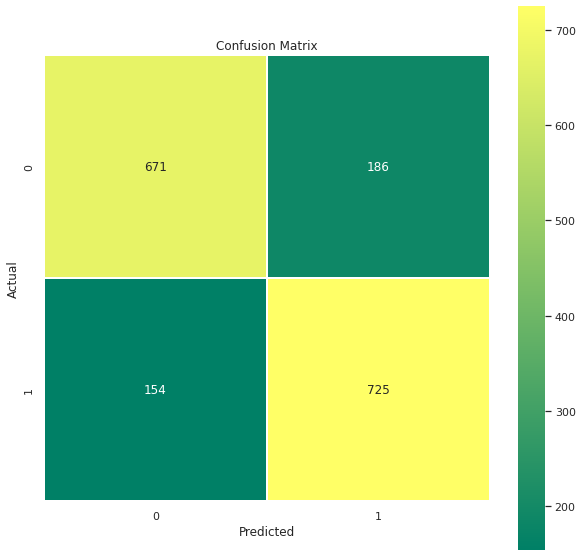

In [823]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_train_test, y_pred), linewidths=0.1, square=True, annot=True, cmap='summer', fmt='3.0f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

По confusion matrix можем увидеть, что 154 пассажира мы классифицировали как не транспортировавшихся, хотя на самом деле они были транспортированы. И 186 классифицировали как транспортровавшиеся, хотя на самом деле были транспортированы. Но все же, большинство мы классифицировали верно. Можно было увеличить полноту, предсказывая больше как 'транспортировавшиеся', уменьшим при этом точность, используя f beta score, но в условиях соревнований этого не требовалось.

**сделаем предсказания для тестовой выборки**

In [824]:
predict = svc_mod.predict(X_test)
predict[:10]    

array([ True, False,  True,  True, False,  True,  True,  True,  True,
        True])

In [825]:
submission = {
    'PassengerId': test_id,
    'Transported': predict
}
solution = pd.DataFrame(submission)
solution.to_csv('data/submission.csv', index=False)